In [1]:
import pandas as pd
from ast import literal_eval
with open("008_results.jsonl", "r") as f:
    contents = f.readlines()
    contents = [literal_eval(i) for i in contents]

df = pd.DataFrame(data=contents)
df = df[df.eval_split.str.contains("test")]
df = df[df.macroF1 > 0.5]
df.tail(2)

,macroF1,y_true,y_pred,train_split,eval_split,model_name
44,0.854513,"[Negative, Negative, Negative, Negative, Other...","[Negative, Negative, Negative, Negative, Other...",train,test_SRB,classla/bcms-bertic
46,0.944272,"[Negative, Other, Negative, Other, Negative, O...","[Negative, Other, Other, Other, Negative, Othe...",train,test_BiH,classla/bcms-bertic


In [2]:
df.groupby(["model_name", "train_split", "eval_split"]).agg(
    {
        "macroF1": lambda i: [round(i, 2) for i in i]
    }

)

macroF1
model_name          train_split eval_split                                      
classla/bcms-bertic train       test          [0.9, 0.9, 0.89, 0.92, 0.91, 0.89]
                                test_BiH    [0.83, 0.83, 0.94, 0.94, 0.94, 0.94]
                                test_HR      [0.93, 0.91, 0.91, 0.95, 0.93, 0.9]
                                test_SRB    [0.87, 0.88, 0.84, 0.87, 0.88, 0.85]

In [3]:
import numpy as np

C_trained_on_train = df.train_split == "train"
C_evaled_on_test = df.eval_split == "test"
from typing import Iterable


def macroF1_stats(i: Iterable[float]) -> str:
    return f"{np.mean(i):0.4f} ± {np.std(i):0.4f}"


gb = df[C_trained_on_train & C_evaled_on_test].groupby(
    "model_name".split()
).agg(
    [macroF1_stats,
     #len
     ]
).rename(columns={"len": "sample size"}).sort_values(
    by=("macroF1", "macroF1_stats"), ascending=False
)
print(gb.to_latex())
gb

\begin{tabular}{ll}
\toprule
{} &          macroF1 \\
{} &    macroF1\_stats \\
model\_name          &                  \\
\midrule
classla/bcms-bertic &  0.8999 ± 0.0120 \\
\bottomrule
\end{tabular}



/home/rupnik/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,macroF1
,macroF1_stats
model_name,
classla/bcms-bertic,0.8999 ± 0.0120


## ~~Is bertic better than cse bert?~~ Not Applicable in this setting as we only have bertic

<Figure size 288x288 with 0 Axes>

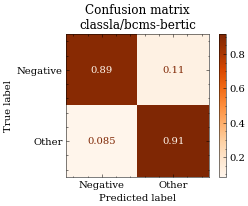

<Figure size 288x288 with 0 Axes>

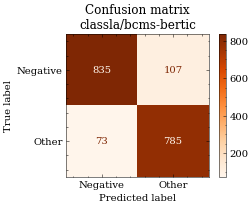

In [4]:
C_model_bertic = df.model_name == "classla/bcms-bertic"
C_trained_on_train = df.train_split == "train"
C_evaled_on_test = df.eval_split == "test"
subset = df[C_trained_on_train & C_evaled_on_test & C_model_bertic
]
import numpy as np
y_true = np.array([np.array(i) for i in subset.y_true]).reshape(-1)
y_pred = np.array([np.array(i) for i in subset.y_pred]).reshape(-1)

import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())
plt.figure(figsize=(4,4))
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Other"],
   normalize="true"
   )

plt.title(f"Confusion matrix\nclassla/bcms-bertic")
plt.savefig("images/008_bertic_cm_normalized_true_train_all_test_all.png")
plt.savefig("images/008_bertic_cm_normalized_true_train_all_test_all.pdf")

plt.show()



import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())
plt.figure(figsize=(4,4))
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Other"],
   # normalize="true"
   )

plt.title(f"Confusion matrix\nclassla/bcms-bertic")
plt.savefig("images/008_bertic_cm_normalized_true_train_all_test_all_nonnorm.png")
plt.savefig("images/008_bertic_cm_normalized_true_train_all_test_all_nonnorm.pdf")

plt.show()

In [9]:
df.groupby(["model_name", "train_split", "eval_split"]).agg(
    [macroF1_stats, len]
)#.sort_values(by=("macroF1","macroF1_stats"), ascending=False)

macroF1     
                                              macroF1_stats  len
model_name          train_split eval_split                      
classla/bcms-bertic train       test        0.8999 ± 0.0120  6.0
                                test_BiH    0.9071 ± 0.0525  6.0
                                test_HR     0.9221 ± 0.0153  6.0
                                test_SRB    0.8660 ± 0.0150  6.0

# Inspecting individual models' performance on cross-parliament data

In [44]:
from IPython.display import display

for model_name in df.model_name.unique():
    print("Model:", model_name)
    C_model = df.model_name == model_name
    C_train_on_fulltrain = df.train_split == "train"
    C_test_on_full_test = df.eval_split == "test"
    gb = df[C_model & (~C_train_on_fulltrain) & (~ C_test_on_full_test)].groupby(["train_split", "eval_split"]).agg(
    macroF1_stats)
    display(gb)

Model: xlm-roberta-base


macroF1
train_split eval_split                 
train_HR    test_HR     0.7296 ± 0.0251
            test_SRB    0.6128 ± 0.0341
train_SRB   test_HR     0.7323 ± 0.0282
            test_SRB    0.6487 ± 0.0203

Model: classla/bcms-bertic


macroF1
train_split eval_split                 
train_HR    test_HR     0.8147 ± 0.0083
            test_SRB    0.7249 ± 0.0105
train_SRB   test_HR     0.7953 ± 0.0207
            test_SRB    0.7130 ± 0.0278

Model: EMBEDDIA/crosloengual-bert


macroF1
train_split eval_split                 
train_HR    test_HR     0.7748 ± 0.0174
            test_SRB    0.7146 ± 0.0175
train_SRB   test_HR     0.7762 ± 0.0114
            test_SRB    0.6989 ± 0.0275

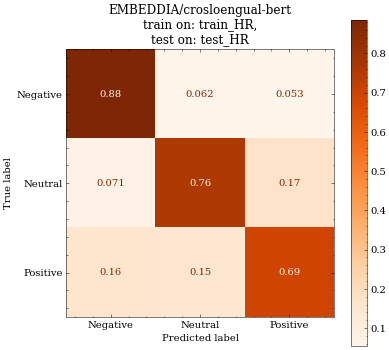

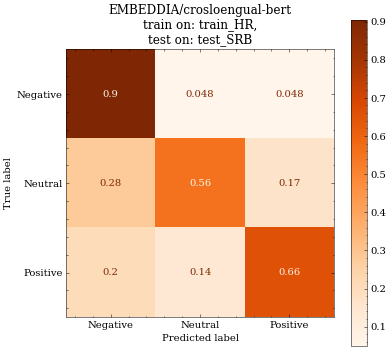

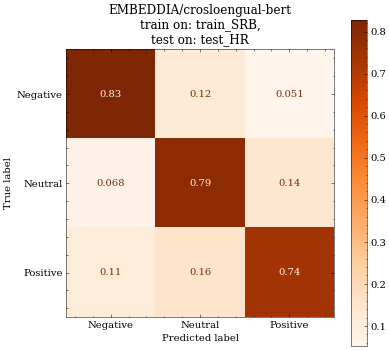

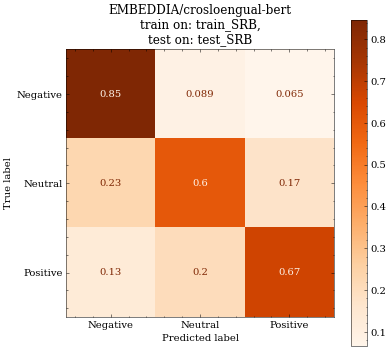

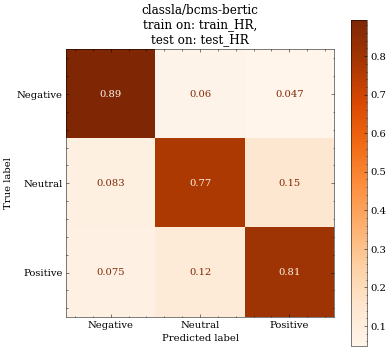

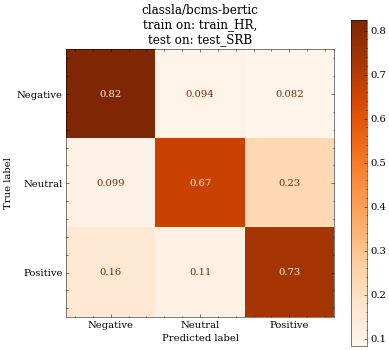

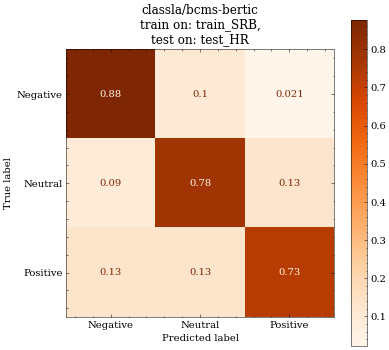

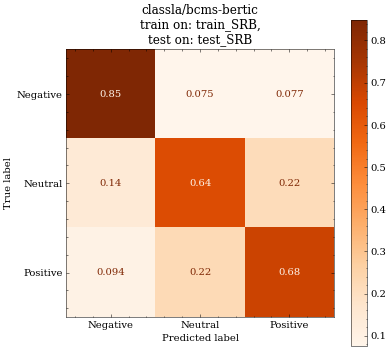

In [45]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])
from sklearn.metrics import ConfusionMatrixDisplay

for model in ["EMBEDDIA/crosloengual-bert", "classla/bcms-bertic"]:
    for train in ["train_HR", "train_SRB"]:
        for test in [
            # "dev_HR", 
            # "dev_SRB", 
            "test_HR", 
            "test_SRB"
            ]:
            C_model = df.model_name==model
            C_train = df.train_split == train
            C_test = df.eval_split == test
            subset = df[C_model & C_train & C_test]
            y_true = []
            y_pred = []
            for i in subset.y_true.values:
                y_true.extend(i)
            for i in subset.y_pred.values:
                y_pred.extend(i)
            fig, ax = plt.subplots(figsize=(6,6))
            ConfusionMatrixDisplay.from_predictions(
            y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"],
            ax = ax,
            normalize="true"
            )
            plt.title(f"{model}\ntrain on: {train},\ntest on: {test}")
            plt.savefig(f"images/CMs/007_{model.replace('/', '_')}_{train=}_{test=}.png")
            plt.savefig(f"images/CMs/007_{model.replace('/', '_')}_{train=}_{test=}.pdf")
            plt.show()